In [37]:
import textblob
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import SentiWordNet as swn
#from nltk.corpus import sentiwordnet as swn

In [38]:
class tweet():
    def __init__(self, timestamp, contents, num_followers, polarity, subjectivity):
        self.timestamp = timestamp
        self.contents = contents
        self.num_followers = num_followers
        self.polarity = polarity
        self.subjectivity = subjectivity

In [39]:
# Parameters:

tweet_filename = 'tweets_mar_dowjones.csv'
stock_filename = 'dji_mar.csv'
daysTraced = 3

In [40]:
# Load Tweets extracted:

tweets_all = []
with open(tweet_filename, 'r') as tweet_file:
    reader = csv.reader(tweet_file)
    next(reader) 
    for row in reader:
        curr_tweet = tweet(row[0], row[1], row[2], row[3], row[4])
        tweets_all.append(curr_tweet)
print(len(tweets_all))

12000


In [41]:
# Polarities pre-process:

time_list = np.unique([t.timestamp[0:10] for t in tweets_all])
polarities = np.zeros((len(time_list), 2))

for i in range(len(time_list)):
    time = time_list[i]
    polarityPos = 0
    polarityNeg = 0
    
    for t in tweets_all:
        if t.timestamp[0:10] == time:
            polarity = float(t.polarity)
            if polarity > 0.0:
                polarityPos += polarity
            elif polarity < 0.0:
                polarityNeg += polarity
                
    polarities[i,0] = polarityPos
    polarities[i,1] = polarityNeg

print(np.shape(polarities))
print(polarities)

(15, 2)
[[ 4.82502079e+01 -3.98560606e+01]
 [ 3.15715681e+01 -1.65129089e+01]
 [ 4.54609704e+01 -7.69599025e+01]
 [ 1.76399098e+01 -7.05334776e+01]
 [ 7.55149303e+01 -4.63537998e+01]
 [ 1.50000000e-01  0.00000000e+00]
 [ 2.63293282e+02 -4.66579254e+01]
 [ 9.07278680e+00 -3.41169553e+00]
 [ 1.02623388e+02 -2.41232693e+01]
 [ 6.02141374e+01 -1.63144841e+01]
 [ 4.13404564e+01 -2.18822481e+01]
 [ 6.02587933e+01 -3.20292154e+01]
 [ 1.24660884e+02 -3.41813047e+01]
 [ 1.51637984e+01 -7.89143519e+00]
 [ 7.77070227e+00 -1.16491963e+02]]


In [42]:
# Format polarities so that relationship is to be found 
# between each days' DJI value and polarities of 3 days before it:

polaritiesX = np.zeros((len(time_list)-(daysTraced-1), daysTraced*2))
for i in range(0, len(polarities)-2):
    for j in range(daysTraced):
        polaritiesX[i,j*2+0] = polarities[i+j,0]
        polaritiesX[i,j*2+1] = polarities[i+j,1]
print(np.shape(polaritiesX))
print(polaritiesX)

(13, 6)
[[ 4.82502079e+01 -3.98560606e+01  3.15715681e+01 -1.65129089e+01
   4.54609704e+01 -7.69599025e+01]
 [ 3.15715681e+01 -1.65129089e+01  4.54609704e+01 -7.69599025e+01
   1.76399098e+01 -7.05334776e+01]
 [ 4.54609704e+01 -7.69599025e+01  1.76399098e+01 -7.05334776e+01
   7.55149303e+01 -4.63537998e+01]
 [ 1.76399098e+01 -7.05334776e+01  7.55149303e+01 -4.63537998e+01
   1.50000000e-01  0.00000000e+00]
 [ 7.55149303e+01 -4.63537998e+01  1.50000000e-01  0.00000000e+00
   2.63293282e+02 -4.66579254e+01]
 [ 1.50000000e-01  0.00000000e+00  2.63293282e+02 -4.66579254e+01
   9.07278680e+00 -3.41169553e+00]
 [ 2.63293282e+02 -4.66579254e+01  9.07278680e+00 -3.41169553e+00
   1.02623388e+02 -2.41232693e+01]
 [ 9.07278680e+00 -3.41169553e+00  1.02623388e+02 -2.41232693e+01
   6.02141374e+01 -1.63144841e+01]
 [ 1.02623388e+02 -2.41232693e+01  6.02141374e+01 -1.63144841e+01
   4.13404564e+01 -2.18822481e+01]
 [ 6.02141374e+01 -1.63144841e+01  4.13404564e+01 -2.18822481e+01
   6.02587933e+01

In [43]:
# Load DJI values:

dji = pd.read_csv('dji_mar.csv').to_numpy()
djiY = (dji[:,1] + dji[:,4]) / 2 
    # average of daily opening and closing price
djiY = djiY[daysTraced:]
print(np.shape(djiY))

(12,)


In [46]:
# Linear regression:

from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(polaritiesX[1:,:], djiY)

# Due to the lack of data, there is no validation set:
print(lr.score(polaritiesX[1:,:], djiY))
dji_hat = lr.predict(polaritiesX[1:,:])

0.6669596064525688


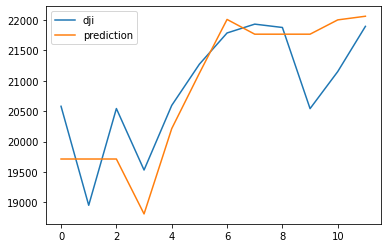

In [47]:
# Prediction results comparing to actual DJI values:
plt.figure()
plt.plot(dji_hat, label="dji")
plt.plot(djiY, label="prediction")
plt.legend()
plt.show()